# Pulling Crime Data for Philly

The City of Philadelphia makes crime incidents data available through a couple locations. Simple *.CSV and *.SHP files can be downloaded by year from the [OpenDataPhilly site](https://opendataphilly.org/datasets/crime-incidents/). Instead of doing any of this by hand, here I use the provided API to programmatically pull data from 2015 to 2020. 

## About the Data

The files downloaded include Part I and Part II crimes from the Philadelphia Police Department. Part I crimes include violent offenses such as aggravated assault, rape, arson, among others. Part II crimes include simple assault, prostitution, gambling, fraud, and other non-violent offenses.

## Pull the Data

The `incidents_part1_part2` dataset published to carto, which allows the user to query the data using SQL through HTTP via Carto's SQL API. To do so, pass the query using the `q` parameter:

```
https://phl.carto.com/api/v2/sql?q=SELECT * FROM incidents_part1_part2
```

Documentation can be found [here](https://cityofphiladelphia.github.io/carto-api-explorer/#incidents_part1_part2).

Let's pull the data using this endpoint and dictionary comprehension to map a function over a range of values.

In [4]:
# Load required libraries:
import requests
import pandas as pd
from pandas import DataFrame
import os

# Declare a list of years:
wanted_years = list(range(2015, 2021))

# Declare an endpoint:
wanted_url = "https://phl.carto.com/api/v2/sql?q=SELECT * FROM incidents_part1_part2"

# Declare a function to pull data from endpoint based on a year:
def pull_by_year(url: str, year: int, verbose: bool = True) -> pd.DataFrame:
    url = url.replace(" ", "%20") +  f"%20WHERE%20dispatch_date%20LIKE%20%27{str(year)}-%25%27"
    if verbose:
        print(f"Requesting data for {url}")
    res = requests.get(url).json()
    out = DataFrame.from_dict(res['rows'])
    return(out)

# Pull five years worth of data:
data = {str(x): pull_by_year(url=wanted_url, year=x) for x in wanted_years}

Requesting data for https://phl.carto.com/api/v2/sql?q=SELECT%20*%20FROM%20incidents_part1_part2%20WHERE%20dispatch_date%20LIKE%20%272015-%25%27
Requesting data for https://phl.carto.com/api/v2/sql?q=SELECT%20*%20FROM%20incidents_part1_part2%20WHERE%20dispatch_date%20LIKE%20%272016-%25%27
Requesting data for https://phl.carto.com/api/v2/sql?q=SELECT%20*%20FROM%20incidents_part1_part2%20WHERE%20dispatch_date%20LIKE%20%272017-%25%27
Requesting data for https://phl.carto.com/api/v2/sql?q=SELECT%20*%20FROM%20incidents_part1_part2%20WHERE%20dispatch_date%20LIKE%20%272018-%25%27
Requesting data for https://phl.carto.com/api/v2/sql?q=SELECT%20*%20FROM%20incidents_part1_part2%20WHERE%20dispatch_date%20LIKE%20%272019-%25%27
Requesting data for https://phl.carto.com/api/v2/sql?q=SELECT%20*%20FROM%20incidents_part1_part2%20WHERE%20dispatch_date%20LIKE%20%272020-%25%27


Store them:

In [8]:
def write_csv_from_dict(folder: str, input_dict: dict, suffix: str) -> None:
    for k,v in input_dict.items():
        file_path = os.path.join(folder, f'{k}_{suffix}.csv')
        v.to_csv(file_path, encoding = 'utf-8', index = False)
        
write_csv_from_dict(folder= "Philly", input_dict=data,
                    suffix="philly_incidents_part1_part2")

## Take a Quick Look

A quick scan at taking a look at whether data look good:

In [47]:
def group_by_day(df: pd.DataFrame, day_var: str) -> None:
    df['date'] = pd.to_datetime(df[day_var])
    out = df.groupby(df['date'].dt.date).size().reset_index(name='dcount')
    return(out)

time_counts = group_by_day(df = pd.concat(data), day_var="dispatch_date_time")

Visually inspect it:

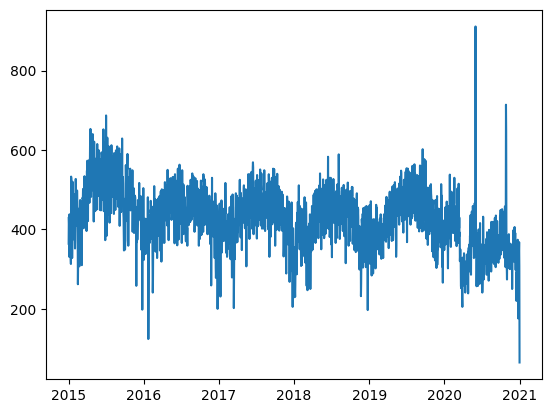

In [48]:
import matplotlib.pyplot as plt

time_counts = time_counts.set_index(time_counts['date'])
plt.plot(time_counts['dcount'])
plt.show()
